In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 불러오기
from numpy.random import seed
seed(101)

from tensorflow import random
random.set_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터가 들어있는 폴더 내 파일이 무엇이 있는지 확인
os.listdir('/content/drive/MyDrive/final_project/data')

['hmnist_28_28_L.csv',
 'HAM10000_metadata.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'HAM10000_images_part_1',
 'ISIC_new_images']

- directory 구조 생성

In [ ]:
# 새로운 directory 생성
base_dir = 'base_dir'
os.mkdir(base_dir)


# base directory 안에 폴더들을 생성

# 'base_dir' 안에 7개의 라벨 폴더들을 성생 :

# train_dir
    # nv (Melanocytic nevi : 멜라닌 모반(점))
    # mel (melanoma : 악성 흑색종)
    # bkl (Benign keratosis : 양성태선각화증)
    # bcc (Basal cell carcinoma : 기저세포암)
    # akiec (Actinic Keratoses and intraepithelial Carcinoma : 광선각화증, 상피내암)
    # vasc (Vascular skin lesions : 혈관피부병변)
    # df (Dermatofibroma : 피부섬유종, 양성 피부병)

# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# base_dir 안에 train_dir, val_dir 생성
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# train, val 각각의 폴더에 7개의 클래스를 구분하는 폴더들을 생성

# train_dir 안에 새로운 7개 클래스 폴더들을 생성
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# val_dir 안에 새로운 7개 클래스 폴더들을 생성
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

- Train Set과 Val Set 생성

In [ ]:
# metadata.csv 파일을 df_data 로 불러옴
# metadata.csv 파일 : lesion_id(병변 ID), image_id(이미지 ID), dx(병변 클래스), age(나이), sex(성별), localization(위치) 등이 포함
# 총 10015개의 data
df_data = pd.read_csv('/content/drive/MyDrive/final_project/data/HAM10000_metadata.csv')

print(df_data.head())
print(len(df_data))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
10015


In [ ]:
df_data.groupby('lesion_id').value_counts()

lesion_id    image_id      dx   dx_type    age   sex     localization   
HAM_0000000  ISIC_0025346  nv   histo      60.0  male    back               1
             ISIC_0028498  nv   histo      60.0  male    back               1
HAM_0000001  ISIC_0027859  bkl  histo      70.0  female  face               1
HAM_0000002  ISIC_0032622  mel  histo      65.0  female  lower extremity    1
             ISIC_0033848  mel  histo      65.0  female  lower extremity    1
                                                                           ..
HAM_0007625  ISIC_0033736  bkl  histo      75.0  male    lower extremity    1
HAM_0007626  ISIC_0031300  nv   follow_up  45.0  male    abdomen            1
HAM_0007627  ISIC_0026118  bcc  histo      80.0  male    chest              1
             ISIC_0029820  bcc  histo      80.0  male    chest              1
HAM_0007628  ISIC_0027059  nv   follow_up  60.0  female  back               1
Length: 9958, dtype: int64

- Create a stratified val set

In [ ]:
# 이 데이터셋은 하나의 병변에 대해 여러개 이미지가 포함된 데이터가 존재
# 중복된 이미지를 가진 legion_id와 하나의 이미지만 가진 legion_id 구분

# 각 병변(lesion) 당 몇 개의 이미지가 들어있는지 확인
df = df_data.groupby('lesion_id').count()

# 병변 당 하나의 이미지만 가지는 데이터만 필터링
# 5514개의 data
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

print(df.head())
print(len(df))

     lesion_id  image_id  dx  dx_type  age  sex  localization
0  HAM_0000001         1   1        1    1    1             1
1  HAM_0000003         1   1        1    1    1             1
2  HAM_0000004         1   1        1    1    1             1
3  HAM_0000007         1   1        1    1    1             1
4  HAM_0000008         1   1        1    1    1             1
5514


In [ ]:
# 여러개 이미지와 하나의 이미지가 포함된 data를 구분하는 함수 정의
def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# lesion_id 행을 복사해 identify_duplicates 함수를 적용해 duplicates 행을 새로 생성
df_data['duplicates'] = df_data['lesion_id']

df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [ ]:
# 중복된 값이 없는 데이터만 추출해 df 생성
df_no_duplicates = df_data[df_data['duplicates'] == 'no_duplicates']

# 중복된 값이 있는 데이터 중 첫 번째 행만 선택하여 df_duplicates 생성
df_duplicates = df_data[df_data['duplicates'] == 'has_duplicates'].drop_duplicates(subset='lesion_id', keep='first')

# df_no_duplicates와 df_duplicates를 합쳐서 최종 df 생성
df = pd.concat([df_no_duplicates, df_duplicates])
print(df.tail())
print(df.shape)

         lesion_id      image_id     dx dx_type   age     sex localization  \
9984   HAM_0006024  ISIC_0029830  akiec   histo  60.0    male         face   
9992   HAM_0004282  ISIC_0033811  akiec   histo  65.0  female         face   
9994   HAM_0000193  ISIC_0030877  akiec   histo  60.0  female         face   
10004  HAM_0005579  ISIC_0029309  akiec   histo  80.0    male         face   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   

           duplicates  
9984   has_duplicates  
9992   has_duplicates  
9994   has_duplicates  
10004  has_duplicates  
10010  has_duplicates  
(7470, 8)


In [ ]:
# 하나의 병변에 하나의 이미지가 포함된 data로 이루어진 df를 활용해 val set 생성
y = df['dx']

_, df_val = train_test_split(df, test_size=0.2, random_state=101, stratify=y) # val set을 20%로 설정

df_val.shape

(1494, 8)

In [ ]:
# val set의 질병 종류별 data 개수를 세어봄
df_val['dx'].value_counts()

nv       1080
bkl       145
mel       123
bcc        65
akiec      46
vasc       20
df         15
Name: dx, dtype: int64

- Create a train set that excludes images that are in the val set

In [ ]:
# train set은 val set에 있는 행을 제외하면 된다

# 이 함수는 이미지가 train set에 포함되는지 val set에 포함되는지 확인
def identify_val_rows(x):
    # val set에 포함된 lesion_id의 리스트를 생성
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# image_id 행을 복사해 identify_val_rows 함수를 적용해 train_or_val 행을 새로 생성
df['train_or_val'] = df['image_id']

df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)

# train rows만 추출해 df_train 생성
df_train = df[df['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

5976
1494


In [ ]:
df_train['dx'].value_counts()

nv       4323
bkl       582
mel       491
bcc       262
akiec     182
vasc       78
df         58
Name: dx, dtype: int64

In [ ]:
df_val['dx'].value_counts()

nv       1080
bkl       145
mel       123
bcc        65
akiec      46
vasc       20
df         15
Name: dx, dtype: int64

- Transfer the Images into the Folders

In [ ]:
# df_data에서 image_id 행을 index로 설정
df_data.set_index('image_id', inplace=True)

In [ ]:
# image가 포함된 폴더를 가져와 train image와 val image를 각각 폴더에 옮김
folder_1 = os.listdir('/content/drive/MyDrive/final_project/data/HAM10000_images_part_1')
folder_2 = os.listdir('/content/drive/MyDrive/final_project/data/HAM10000_images_part_2')

# train과 val 데이터의 image_id의 리스트를 가져옴
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# train data 이미지를 옮김
for image in train_list:

    fname = image + '.jpg'

    # 이미지 파일의 이름이 실제로 'ISIC_0025276.jpg'와 같은 형태로 되어 있는지 확인
    #if image not in df_data['image_id'].values:
        #continue

    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # 이미지 파일들이 들어있는 경로
        src = os.path.join('/content/drive/MyDrive/final_project/data/HAM10000_images_part_1', fname)
        # 이미지 파일들이 옮겨져야하는 위치의 경로
        dst = os.path.join(train_dir, label, fname)
        # 이미지 파일들을 directory로 옮김
        shutil.copyfile(src, dst)

    if fname in folder_2: # part_1폴더와 동일하게 part_2폴더에서도 수행
        src = os.path.join('/content/drive/MyDrive/final_project/data/HAM10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


# train data와 같은 방식으로 val data 이미지도 옮김
for image in val_list:

    fname = image + '.jpg'

    # 이미지 파일의 이름이 실제로 'ISIC_0025276.jpg'와 같은 형태로 되어 있는지 확인
    #if image not in df_data['image_id'].values:
        #continue

    label = df_data.loc[image,'dx']

    if fname in folder_1:
        src = os.path.join('/content/drive/MyDrive/final_project/data/HAM10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('/content/drive/MyDrive/final_project/data/HAM10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

In [ ]:
# train_dir의 각 질병 클래스 폴더에 몇 개의 이미지가 포함되었는지 확인

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

4323
491
582
262
182
78
58


In [ ]:
# val_dir의 각 질병 클래스 폴더에 몇 개의 이미지가 포함되었는지 확인

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

1080
123
145
65
46
20
15


In [ ]:
## ISIC 추가 데이터 삽입
# mel(o), bcc(o), bkl(o), df(o), vasc(o), akiec(o)
import os
import shutil

def copy_non_duplicate_images(train_folder, new_images_folder, val_folder):
    # train 폴더와 val 폴더 내의 이미지 파일 목록 가져오기
    train_images = set(os.listdir(train_folder))
    val_images = set(os.listdir(val_folder))

    # 새로 추가할 이미지 폴더 내의 이미지 파일 목록 가져오기
    new_images = set(os.listdir(new_images_folder))

    # 중복되지 않은 이미지를 train 폴더에 추가
    for image in new_images:
        if image not in train_images and image not in val_images:
            src = os.path.join(new_images_folder, image)
            dst = os.path.join(train_folder, image)
            shutil.copyfile(src, dst)

# 사용 예시
train_folder_path = '/content/base_dir/train_dir/akiec'
new_images_folder_path = '/content/drive/MyDrive/final_project/data/ISIC_new_images/akiec'
val_folder_path = '/content/base_dir/val_dir/akiec'

copy_non_duplicate_images(train_folder_path, new_images_folder_path, val_folder_path)

# 확인 메시지 출력
print("Non-duplicate images copied to the train folder.")

Non-duplicate images copied to the train folder.


In [ ]:
### 폴더 내 이미지가 잘 들어갔는지 개수 확인
# nv(4323), mel(7810), bcc(5183), bkl(1921), df(478), vasc(426), akiec(1549)
import os

# 확인하려는 디렉토리 경로
directory_path = '/content/base_dir/train_dir/akiec'

# 해당 디렉토리 내 파일 리스트 가져오기
file_list = os.listdir(directory_path)

# 이미지 파일의 개수 확인
image_count = sum(1 for file in file_list if file.lower().endswith(('.png', '.jpg', '.jpeg')))

print(f"The number of image files in the directory: {image_count}")

The number of image files in the directory: 1549


In [ ]:
## 이미지가 옮겨진 directory 구글 드라이브에 저장
from google.colab import drive
import shutil
import os

# 만들어진 디렉토리 경로
colab_dir_path = '/content/base_dir'

# Google 드라이브 상의 디렉토리 경로
drive_dir_path = '/content/drive/MyDrive/final_project/base_dir'

# 디렉토리 복사
shutil.copytree(colab_dir_path, drive_dir_path)

# 확인 메시지 출력
print(f"Directory copied from Colab to Google Drive: {drive_dir_path}")

Directory copied from Colab to Google Drive: /content/drive/MyDrive/final_project/base_dir


In [ ]:
##### base_dir 가 공유 드라이브에 저장됨 #####

In [ ]:
### 폴더 내 이미지가 잘 들어갔는지 개수 확인
# nv(4323), mel(7810), bcc(5183), bkl(1921), df(478), vasc(426), akiec(1549)
import os

# 확인하려는 디렉토리 경로
directory_path = '/content/drive/MyDrive/final_project/skin_cancer/train_dir/mel'

# 해당 디렉토리 내 파일 리스트 가져오기
file_list = os.listdir(directory_path)

# 이미지 파일의 개수 확인
image_count = sum(1 for file in file_list if file.lower().endswith(('.png', '.jpg', '.jpeg')))

print(f"The number of image files in the directory: {image_count}")

The number of image files in the directory: 3248


- 이미지 증강
- Copy the train images into aug_dir

In [ ]:
# class 'nv'(멜라닌 모반, 점)은 데이터가 많으므로 증강을 진행하지 않음
# 새로 이미지를 넣은 폴더에는 mel이 가장 많으므로 mel은 증강을 진행하지않음
# mel, bcc 제외하고 이미지 증강(3000개)
class_list = ['mel']

for item in class_list:

    # 이미지 증강이 이루어질 일시적인 directory 'aug_dir'을 생성
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # 같은 클래스의 이미지를 저장하기 위한 img_dir을 aug_dir 내에 생성
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # 클래스 하나를 고름
    img_class = item

    # 선택한 클래스 directory 안에 있는 모든 이미지들을 나열
    img_list = os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/' + img_class)

    # 클래스 train directory에 있는 이미지들을 img_dir에 복사
    for fname in img_list:
            # 이미지 파일들이 들어있는 경로
            src = os.path.join('/content/drive/MyDrive/final_project/skin_cancer/train_dir/' + img_class, fname)
            # 이미지 파일들이 옮겨져야하는 위치의 경로
            dst = os.path.join(img_dir, fname)
            # 이미지 파일들을 directory로 옮김
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    # 이미지 자체가 아닌 이미지를 포함하는 dir를 가리킵니다
    path = aug_dir
    save_path = '/content/drive/MyDrive/final_project/skin_cancer/train_dir/' + img_class

    # ImageDataGenerator 클래스 생성
    datagen = ImageDataGenerator(
        rotation_range=180, # 회전
        width_shift_range=0.1, # 이동
        height_shift_range=0.1,
        zoom_range=0.1, # 확대
        horizontal_flip=True, # 뒤집기
        vertical_flip=True,
        # brightness_range=(0.9,1.1),
        fill_mode='nearest') # 여백을 가까운 값으로 채움

    batch_size = 50

    # datagen 클래스를 통해 train data에 대해 이미지 증강 진행
    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    ###########

    num_aug_images_wanted = 3200 # # 각 클래스당 7800개 정도의 이미지를 가지길 원함

    ###########

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # generator를 실행하고 약 7800개의 증강된 이미지를 생성
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # 일시적으로 생성한 aug_dir 디렉토리를 삭제
    shutil.rmtree('aug_dir')

Found 2598 images belonging to 1 classes.


In [ ]:
# 각각의 폴더의 몇 개의 train 이미지들이 있는지 확인
# 원본 이미지들에 증강된 이미지들이 포함된 개수이다

print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/train_dir/df')))

3256
3248
3021
3157
3051
2906
2918


- 이미지 전처리

털제거 전처리 수행

In [ ]:
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage import filters as skifilters
%matplotlib inline
import glob

def occlusion_removal(img,threshold=12,SE_radius=6):
    # Remove Dark Hair Occlusions in Dermatoscopic Images via LUV Color Space
    # Using cv2.cvtColor() method
    # Using cv2.COLOR_RGB2LUV color space
    luv       = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)

    # Morphological Closing via Spherical SE
    # Using Elliptical shaped kernal
    kernel    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(SE_radius,SE_radius))
    closing   = cv2.morphologyEx(luv, cv2.MORPH_CLOSE, kernel)

    # Generate Masks via Hysteresis Thresholding Difference Image in L Channel
    diffc      = closing[:,:,0]-luv[:,:,0]
    maskc      = (skifilters.apply_hysteresis_threshold(diffc,threshold,80)).astype(np.uint8)*255


    mask_3dc   = maskc[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]
    basec      = cv2.bitwise_not(maskc)
    base_3dc   = basec[:,:,None] * np.ones(3,dtype=np.uint8)[None, None, :]

    # Restitch Preprocessed Image
    preimagec  = ((base_3dc/255)*luv).astype(np.uint8)
    postimagec = ((mask_3dc/255)*closing).astype(np.uint8)
    fullc      = preimagec + postimagec
    outputc    = cv2.cvtColor(fullc, cv2.COLOR_Luv2RGB)

    return outputc, maskc

In [ ]:
def process_and_save_images(input_folder_path, output_folder_path):
    # 입력 폴더가 없으면 생성
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # 입력 폴더 내 모든 이미지에 대해 수행
    for filename in os.listdir(input_folder_path):
        # 이미지 파일인 경우에만 처리
        if filename.lower().endswith((".jpg", ".png")):
            input_image_path = os.path.join(input_folder_path, filename)

            # 이미지 읽기
            raw_img = cv2.imread(input_image_path)

            # occlusion_removal 함수를 사용하여 이미지 처리
            processed_img, mask = occlusion_removal(raw_img)

            # 결과 이미지 저장
            output_image_path = os.path.join(output_folder_path, f'processed_{filename}')
            cv2.imwrite(output_image_path, processed_img)

            print(f"Image {filename} processed and saved to {output_image_path}")

# 입력 및 출력 경로 설정
input_folder_path = '/content/drive/MyDrive/final_project/skin_cancer/train_dir/akiec'
output_folder_path = '/content/save/akiec'

# 이미지 처리 및 저장 함수 호출
process_and_save_images(input_folder_path, output_folder_path)

Image _900_9898084.jpg processed and saved to /content/save/akiec/processed__900_9898084.jpg
Image _464_7600768.jpg processed and saved to /content/save/akiec/processed__464_7600768.jpg
Image _550_3273296.jpg processed and saved to /content/save/akiec/processed__550_3273296.jpg
Image _328_5679867.jpg processed and saved to /content/save/akiec/processed__328_5679867.jpg
Image _230_7488688.jpg processed and saved to /content/save/akiec/processed__230_7488688.jpg
Image _1256_8709328.jpg processed and saved to /content/save/akiec/processed__1256_8709328.jpg
Image _73_7000015.jpg processed and saved to /content/save/akiec/processed__73_7000015.jpg
Image _452_144718.jpg processed and saved to /content/save/akiec/processed__452_144718.jpg
Image _883_4063008.jpg processed and saved to /content/save/akiec/processed__883_4063008.jpg
Image _1352_1626706.jpg processed and saved to /content/save/akiec/processed__1352_1626706.jpg
Image _1133_5108081.jpg processed and saved to /content/save/akiec/pro

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/final_project/skin_cancer/remove_train_dir/df')))

3256
3248
3021
3157
3049
2906
2918


In [ ]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

- Set Up the Generators

In [ ]:
# train data와 val data의 각 epoch에서 처리될 batch size 설정
train_path = '/content/save'
valid_path = '/content/drive/MyDrive/final_project/base_dir/val_dir'

num_train_samples = 21557 #len(df_train)
num_val_samples = 1494 #len(df_val)
train_batch_size = 50
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# mobilenet모델 입력을 위한 데이터 증강 및 이미지 전처리 진행
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

# train data, val data, test data에 대한 이미지 배치를 생성
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# test data는 shuffle=False 파라미터를 통해 섞이지 않도록 한다.
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 21555 images belonging to 7 classes.
Found 1494 images belonging to 7 classes.
Found 1494 images belonging to 7 classes.


- Modify MobileNet Model

In [ ]:
# mobilenet 모델을 불러옴
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
type(mobile.layers)

list

In [ ]:
# mobilenet 모델은 총 91개의 레이어층을 가짐
len(mobile.layers)

91

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
# 위 모델에서 마지막 5개의 레이어를 포함
# 이는 global_average_pooling2d 레이어를 포함하여 해당 레이어까지 모두 포함합니다
x = mobile.layers[-5].output

# GlobalAveragePooling2D 대신 Flatten 레이어 사용
x = Flatten()(x)

# 새로운 예측을 위한 Dense 레이어를 생성.
# 7은 클래스의 개수에 해당
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input은 입력 레이어를 선택하고,
# outputs=predictions는 위에서 만든 Dense 레이어를 참조합니다.
model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

- Train the Model

In [ ]:
# Top2 and Top3 Accuracy를 나타내는 함수 정의

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
# 모델 컴파일
# Adam 옵티마이저를 사용하고, learning_rates는 0.01로 설정
# 손실 함수는 categorical_crossentropy를 사용
# 평가 함수로는 categorical_accuracy, top_2_accuracy, top_3_accuracy를 사용.
from tensorflow.keras.optimizers import Adamax

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [ ]:
# 각 인덱스에 연결된 레이블 확인
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# melanoma(악성 흑색종, 암)에 대해 더 정확하게 감지하기 위해 가중치 조정

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
# 모델 학습 진행
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

# 훈련 후에 모델 저장
final_filepath = "add_model.h5"
model.save(final_filepath)

Epoch 1/30
432/432 [==============================] - ETA: 0s - loss: 0.8004 - categorical_accuracy: 0.7161 - top_2_accuracy: 0.8846 - top_3_accuracy: 0.9503
Epoch 1: val_top_3_accuracy improved from -inf to 0.92035, saving model to model.h5
432/432 [==============================] - 165s 374ms/step - loss: 0.8004 - categorical_accuracy: 0.7161 - top_2_accuracy: 0.8846 - top_3_accuracy: 0.9503 - val_loss: 1.9412 - val_categorical_accuracy: 0.5120 - val_top_2_accuracy: 0.8313 - val_top_3_accuracy: 0.9203 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
432/432 [==============================] - ETA: 0s - loss: 0.4960 - categorical_accuracy: 0.8163 - top_2_accuracy: 0.9463 - top_3_accuracy: 0.9843
Epoch 2: val_top_3_accuracy improved from 0.92035 to 0.94444, saving model to model.h5
432/432 [==============================] - 159s 368ms/step - loss: 0.4960 - categorical_accuracy: 0.8163 - top_2_accuracy: 0.9463 - top_3_accuracy: 0.9843 - val_loss: 0.8429 - val_categorical_accuracy: 0.7577 - val_top_2_accuracy: 0.8849 - val_top_3_accuracy: 0.9444 - lr: 0.0010
Epoch 3/30
432/432 [==============================] - ETA: 0s - loss: 0.3863 - categorical_accuracy: 0.8602 - top_2_accuracy: 0.9634 - top_3_accuracy: 0.9905
Epoch 3: val_top_3_accuracy did not improve from 0.94444
432/432 [==============================] - 163s 379ms/step - loss: 0.3863 - categorical_accuracy: 0.8602 - top_2_accuracy: 0.9634 - top_3_accuracy: 0.9905 - val_loss: 0.9391 - val_categorical_accuracy: 0.7530 - val_top_2_accuracy: 0.8762 - val_top_3_accuracy: 

- Evaluate the model using the val set

In [ ]:
# evaluate_generator에 사용될 함수들 이름을 가져옴
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [ ]:
# best epoch에 대한 정확도 출력

model.load_weights('add_model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=1494)#len(df_val)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

1494/1494 [==============================] - 14s 10ms/step - loss: 0.9133 - categorical_accuracy: 0.7483 - top_2_accuracy: 0.8695 - top_3_accuracy: 0.9331
val_loss: 0.9132528901100159
val_cat_acc: 0.7483266592025757
val_top_2_acc: 0.8694779276847839
val_top_3_acc: 0.9330655932426453


- Plot the Training Curves

In [ ]:
# 'loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy' 에 대한 train과 val 그래프 출력

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

- Create a Confusion Matrix

In [ ]:
# 테스트 이미지들에 대한 라벨을 가져옴
test_labels = test_batches.classes

In [ ]:
# 각 라벨이 어떤 클래스에 해당하는지 확인
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
# 예측을 수행
predictions = model.predict(test_batches, steps=1494, verbose=1)#len(df_val), verbose=1)

1494/1494 [==============================] - 15s 10ms/step


In [ ]:
predictions.shape

(1494, 7)

In [ ]:
# confusion matrix를 만드는 함수를 정의

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(1494,)

In [ ]:
# argmax는 행에서 최댓값의 인덱스를 반환
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[ 33  11   1   0   0   1   0]
 [  3  57   0   0   1   3   1]
 [ 16  23  80   0   9  17   0]
 [  3   1   0   8   0   3   0]
 [ 15  11  19   0  46  31   1]
 [ 11  48  23  16 102 876   4]
 [  0   1   0   0   0   1  18]]


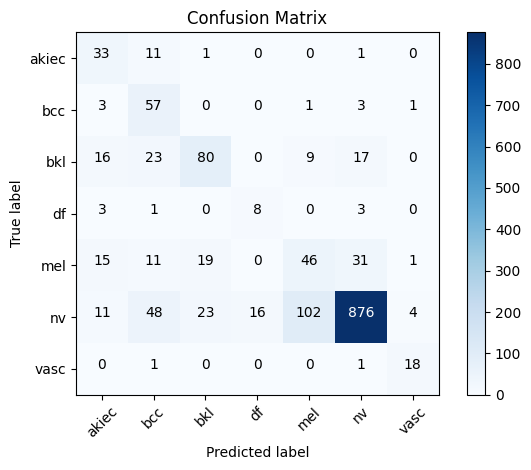

In [ ]:
# confusion matrix 확인
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

- Generate the Classification Report

In [ ]:
# 가장 높은 확률 점수를 가진 클래스의 인덱스를 가져옴
y_pred = np.argmax(predictions, axis=1)

# 테스트 이미지의 레이블을 가져
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# classification report 생성
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.41      0.72      0.52        46
         bcc       0.38      0.88      0.53        65
         bkl       0.65      0.55      0.60       145
          df       0.33      0.53      0.41        15
         mel       0.29      0.37      0.33       123
          nv       0.94      0.81      0.87      1080
        vasc       0.75      0.90      0.82        20

    accuracy                           0.75      1494
   macro avg       0.54      0.68      0.58      1494
weighted avg       0.81      0.75      0.77      1494



In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

In [ ]:
#### 모델 테스트 ####
# 암인거) 'akiec': 0(광선각화증, 상피내암), 'bcc': 1(기저세포암), 'mel': 4(악성흑색종, 암)
# 암 아닌거) 'bkl': 2(양성태선각화증), 'df': 3(피부섬유종, 양성 피부병), 'nv': 5(멜라닌모반, 점), 'vasc': 6(혈관피부병변)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
import numpy as np

# 모델 불러오기
load_model = tf.keras.models.load_model('/content/add_model.h5', custom_objects={'top_2_accuracy': top_2_accuracy, 'top_3_accuracy': top_3_accuracy})

1/1 [==============================] - 0s 20ms/step
Top 3 Predictions:
1: Class Index: 6, Probability: 0.9767
2: Class Index: 1, Probability: 0.0107
3: Class Index: 5, Probability: 0.0084


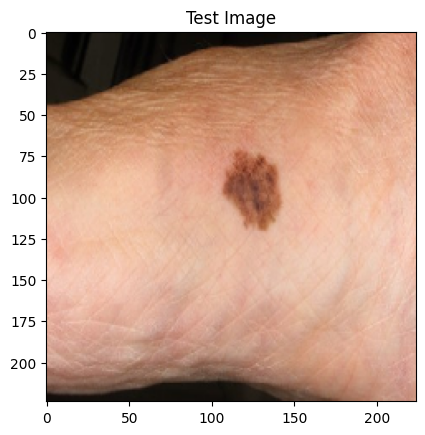

In [ ]:
# 테스트할 이미지 경로
image_path = '/content/다운로드 (1).jpg'  # 실제 이미지 파일 경로로 수정

# 이미지 불러오기 및 전처리
img = image.load_img(image_path, target_size=(224, 224))  # 모델의 입력 크기에 맞게 조정
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 모델에 이미지 전달하여 예측 수행
predictions = load_model.predict(img_array)

# 상위 세 개의 클래스 인덱스 및 확률값 찾기
top_classes = np.argsort(predictions[0])[-3:][::-1]  # 상위 세 개의 클래스 인덱스
top_probs = predictions[0, top_classes]  # 상위 세 개의 확률값

# 예측 결과 출력
print("Top 3 Predictions:")
for i, (class_index, prob) in enumerate(zip(top_classes, top_probs), 1):
    print(f"{i}: Class Index: {class_index}, Probability: {prob:.4f}")

# 이미지 시각화 (옵션)
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title('Test Image')
plt.show()

1/1 [==============================] - 0s 23ms/step
Top 3 Predictions:
1: Class Index: 3, Probability: 0.6225
2: Class Index: 4, Probability: 0.2194
3: Class Index: 1, Probability: 0.1088


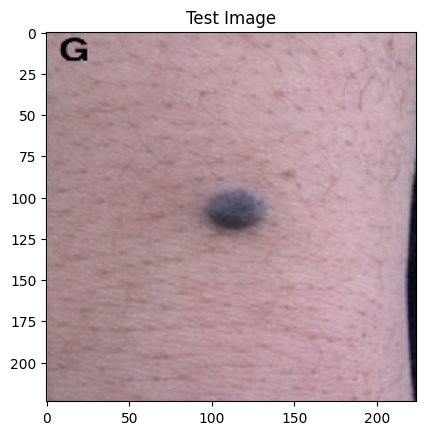

In [ ]:
# 테스트할 이미지 경로
image_path = '/content/다운로드 (2).jpg'  # 실제 이미지 파일 경로로 수정

# 이미지 불러오기 및 전처리
img = image.load_img(image_path, target_size=(224, 224))  # 모델의 입력 크기에 맞게 조정
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 모델에 이미지 전달하여 예측 수행
predictions = load_model.predict(img_array)

# 상위 세 개의 클래스 인덱스 및 확률값 찾기
top_classes = np.argsort(predictions[0])[-3:][::-1]  # 상위 세 개의 클래스 인덱스
top_probs = predictions[0, top_classes]  # 상위 세 개의 확률값

# 예측 결과 출력
print("Top 3 Predictions:")
for i, (class_index, prob) in enumerate(zip(top_classes, top_probs), 1):
    print(f"{i}: Class Index: {class_index}, Probability: {prob:.4f}")

# 이미지 시각화 (옵션)
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title('Test Image')
plt.show()